<font size="12">Snow and Cloud Classification in Historical SPOT Images: An Image Emulation Approach for Training a Deep Learning Model Without Reference Data</font>

In [1]:
project_dir = "/home/ad/barrouz/zacharie/PHD_ZBD"


In [2]:
# A) CREATE TRAINING DATASET FOR THE UNET

In [3]:
# A.1) CREATE A GKDE DISTRIBUTION OF SWH SATURATION AND MINIMUM REFLECTANCE VALUES

In [2]:
# A.1.1) GET CSV OF SATURATION AND MINIMUM REFLECTANCE VALUES FROM SWH USING S3FS
#use kernel s3-env
#if s3fs generate errors, try running the command 'kinit' (followed by pwd) in the console before trying again.
import os
import json

area = "PYR"
os.system(f"mkdir -p {project_dir}/DATA/SWH_SATURATIONS/{area}")
bbox= [48,257,55,262] # bounding box using the SWH path/row (K,J) tiling system [Kmin,Jmin,Kmax,Jmax]
                             # Pyrenees: [36,263,45,265]; French Alps: [48,257,55,262]
start_year= 1986
end_year = 2015
bw= 0.1# bw_method (parameter used by the scipy gaussian_kde tool)



jb_script=f"{project_dir}/CODE/trex/get_swh_saturation_job.sh"

for year in range(start_year,end_year+1):
    common_name = f"{year}_{bbox[0]}-{bbox[2]}_{bbox[1]}-{bbox[3]}"
    config = {
        "work_dir":project_dir+"/DATA/SWH_SATURATIONS/"+area,
        "bbox": bbox,
        "start_date": f"{year}0101", 
        "end_date": f"{year}1231", 
    }

    with open(f"{project_dir}/CODE/config/get_swh_saturation_{common_name}.config", "w") as outfile:
        json.dump(config, outfile)

    export =  ",".join(
        [
            f"config_file=\"{project_dir}/CODE/config/get_swh_saturation_{common_name}.config\""
        ]
    )

    job_common_params =  " ".join(
        [
            "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
            " --job-name=SWH_SAT",
            " --time=00:59:59",
            "-N","1","-n","1",
            "--mem=1G",
            "-o",f"{project_dir}/CODE/logs/LOG_SWH_SAT_JOB_{common_name}",
            f"--export={export}",jb_script
        ]
    )

    os.system("sbatch "+job_common_params)   

Submitted batch job 24452522
Submitted batch job 24452523
Submitted batch job 24452524
Submitted batch job 24452525
Submitted batch job 24452526
Submitted batch job 24452527
Submitted batch job 24452528
Submitted batch job 24452529
Submitted batch job 24452530
Submitted batch job 24452531
Submitted batch job 24452532
Submitted batch job 24452533
Submitted batch job 24452534
Submitted batch job 24452535
Submitted batch job 24452536
Submitted batch job 24452537
Submitted batch job 24452538
Submitted batch job 24452539
Submitted batch job 24452540
Submitted batch job 24452541
Submitted batch job 24452542
Submitted batch job 24452543
Submitted batch job 24452544
Submitted batch job 24452545
Submitted batch job 24452546
Submitted batch job 24452547
Submitted batch job 24452548
Submitted batch job 24452549
Submitted batch job 24452550
Submitted batch job 24452551


In [3]:
# A.1.2) GENERATE GKDE from CSVs
import os
import json

area = "PYR"
jb_script=f"{project_dir}/CODE/trex/get_swh_gkde_job.sh"


config = {
    "work_dir":f"{project_dir}/DATA/SWH_SATURATIONS/{area}",
    "bw": 0.1
}

with open(f"{project_dir}/CODE/config/get_swh_GKDE.config", "w") as outfile:
    json.dump(config, outfile)

export =  ",".join(
    [
        f"config_file=\"{project_dir}/CODE/config/get_swh_GKDE.config\""
    ]
)

job_common_params =  " ".join(
    [
        "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
        " --job-name=SWH_GKDE",
        " --time=00:59:59",
        "-N","1","-n","1",
        "--mem=1G",
        "-o",f"{project_dir}/CODE/logs/LOG_SWH_GKDE_JOB",
        f"--export={export}",jb_script
    ]
)

os.system("sbatch "+job_common_params)   

Submitted batch job 22263220


0

In [ ]:
#A.2) DOWNLOAD SENTINEL-2 DATA (L1C REFLECTANCE, MAJA CLOUD MASKS, SNOW)

In [14]:
import sys,os
import pathlib
os.getcwd()

'/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/PHD_ZBD_SNOW_TRENDS/CODE'

In [ ]:
#A.2.1) USE AMALTHEE TO FIND APPROPRIATE S2 L1C, L2A AND SNOW PRODUCTS
#use kernel Amalthee_TREX
# in this example we look for Sentinel-2 data over the pyrenees
from libamalthee import Amalthee
from datetime import datetime
import pandas as pd
import os


cloud_range = "[0,90]"
start_date = "2016-01-01"
end_date="2019-12-31"



tiles=[["30TXN","94"],["30TYN","51"],["31TCH","51"],["31TDH","8"]] #for the Pyrenees: [tile name,relative orbit number]

df_list = []
for tile,ron in tiles:
    
    #L1C
    parameters = {"processingLevel": "LEVEL1C", "tileid": tile,"cloudCover":cloud_range,"relativeOrbitNumber":ron}
    amalthee_peps = Amalthee('peps')
    amalthee_peps.search("S2ST",f"{start_date}",f"{end_date}",parameters)
    df_L1C = amalthee_peps.products
    print("L1C",len(df_L1C))
    df_L1C['datetime'] =  pd.to_datetime(df_L1C['acquisition_date'])
    df_L1C['month'] = df_L1C['datetime'].dt.strftime('%m')
    df_L1C['day'] = df_L1C['datetime'].dt.strftime('%d')
    df_L1C['year'] = df_L1C['datetime'].dt.strftime('%Y')
    df_L1C['tile'] = tile
    df_L1C["ID"] = df_L1C.index
    df_L1C["LEVEL"] = "L1C"
    df_L1C["area"] = "PYR"
    df_list.append(df_L1C)
    #L2A
    parameters = {"processingLevel": "LEVEL2A", "location": "T"+tile,"cloudCover":cloud_range,"relativeOrbitNumber":ron}
    amalthee_theia = Amalthee('theia')
    amalthee_theia.search("SENTINEL2",f"{start_date}",f"{end_date}",parameters)
    df_L2A = amalthee_theia.products
    print("L2A",len(df_L2A))
    df_L2A['datetime'] =  pd.to_datetime(df_L2A['acquisition_date'],format='%Y%m%d-%H%M%S-%f')
    df_L2A['month'] = df_L2A['datetime'].dt.strftime('%m')
    df_L2A['day'] = df_L2A['datetime'].dt.strftime('%d')
    df_L2A['year'] = df_L2A['datetime'].dt.strftime('%Y')
    df_L2A['tile'] = tile
    df_L2A["ID"] = df_L2A.index
    df_L2A["LEVEL"] = "L2A"
    df_L2A["area"] = "PYR"
    df_list.append(df_L2A)
    #Snow
    parameters = {"processingLevel": "L2B-SNOW", "location": "T"+tile,"cloudCover":cloud_range,"relativeOrbitNumber":ron}
    amalthee_theia = Amalthee('theia')
    amalthee_theia.search("Snow",f"{start_date}",f"{end_date}",parameters)
    df_SNOW = amalthee_theia.products
    print("L2B",len(df_SNOW))
    df_SNOW['datetime'] =  pd.to_datetime(df_SNOW['acquisition_date'],format='%Y%m%d-%H%M%S-%f')
    df_SNOW['month'] = df_SNOW['datetime'].dt.strftime('%m')
    df_SNOW['day'] = df_SNOW['datetime'].dt.strftime('%d')
    df_SNOW['year'] = df_SNOW['datetime'].dt.strftime('%Y')
    df_SNOW['tile'] = tile
    df_SNOW["ID"] = df_SNOW.index
    df_SNOW["LEVEL"] = "L2B"
    df_SNOW["area"] = "PYR"
    df_list.append(df_SNOW)
    
    

tiles=[["31TGM","108"],["31TGL","108"],["31TGK","108"],["31TGJ","108"],["32TLS","108"],["32TLR","108"],["32TLQ","108"],["32TLP","108"]] # for the french Alps
for tile,ron in tiles:
    
    #L1C
    parameters = {"processingLevel": "LEVEL1C", "tileid": tile,"cloudCover":cloud_range,"relativeOrbitNumber":ron}
    amalthee_peps = Amalthee('peps')
    amalthee_peps.search("S2ST",f"{start_date}",f"{end_date}",parameters)
    df_L1C = amalthee_peps.products
    print("L1C",len(df_L1C))
    df_L1C['datetime'] =  pd.to_datetime(df_L1C['acquisition_date'])
    df_L1C['month'] = df_L1C['datetime'].dt.strftime('%m')
    df_L1C['day'] = df_L1C['datetime'].dt.strftime('%d')
    df_L1C['year'] = df_L1C['datetime'].dt.strftime('%Y')
    df_L1C['tile'] = tile
    df_L1C["ID"] = df_L1C.index
    df_L1C["LEVEL"] = "L1C"
    df_L1C["area"] = "ALP"
    df_list.append(df_L1C)
    #L2A
    parameters = {"processingLevel": "LEVEL2A", "location": "T"+tile,"cloudCover":cloud_range,"relativeOrbitNumber":ron}
    amalthee_theia = Amalthee('theia')
    amalthee_theia.search("SENTINEL2",f"{start_date}",f"{end_date}",parameters)
    df_L2A = amalthee_theia.products
    print("L2A",len(df_L2A))
    df_L2A['datetime'] =  pd.to_datetime(df_L2A['acquisition_date'],format='%Y%m%d-%H%M%S-%f')
    df_L2A['month'] = df_L2A['datetime'].dt.strftime('%m')
    df_L2A['day'] = df_L2A['datetime'].dt.strftime('%d')
    df_L2A['year'] = df_L2A['datetime'].dt.strftime('%Y')
    df_L2A['tile'] = tile
    df_L2A["ID"] = df_L2A.index
    df_L2A["LEVEL"] = "L2A"
    df_L2A["area"] = "ALP"
    df_list.append(df_L2A)
    #Snow
    parameters = {"processingLevel": "L2B-SNOW", "location": "T"+tile,"cloudCover":cloud_range,"relativeOrbitNumber":ron}
    amalthee_theia = Amalthee('theia')
    amalthee_theia.search("Snow",f"{start_date}",f"{end_date}",parameters)
    df_SNOW = amalthee_theia.products
    print("L2B",len(df_SNOW))
    df_SNOW['datetime'] =  pd.to_datetime(df_SNOW['acquisition_date'],format='%Y%m%d-%H%M%S-%f')
    df_SNOW['month'] = df_SNOW['datetime'].dt.strftime('%m')
    df_SNOW['day'] = df_SNOW['datetime'].dt.strftime('%d')
    df_SNOW['year'] = df_SNOW['datetime'].dt.strftime('%Y')
    df_SNOW['tile'] = tile
    df_SNOW["ID"] = df_SNOW.index
    df_SNOW["LEVEL"] = "L2B"
    df_SNOW["area"] = "ALP"
    df_list.append(df_SNOW)
    

#concatenate the dataframes into one dataframe referencing one S2 scene per tile and per month of the year

df = pd.concat(df_list).sample(frac=1).drop_duplicates(subset=['day','month','year','tile','area','LEVEL'])
df = df.pivot(index=["year", "month",'day','tile','area'], columns=["LEVEL"], values="ID")
df =df.dropna().reset_index()
df = df.sample(frac=1).drop_duplicates(subset=['day','month','year','area'])
df = df.groupby(['tile','month']).sample(1)
df['L1C_PATH'] = "/work/datalake/S2-L1C/" + df['tile'] + "/"+ df['year'] + "/" + df['month'] + "/"+ df['day'] + "/"+ df[f'L1C']+".SAFE"
df['L2A_PATH'] = "/work/datalake/S2-L2A-THEIA/" + df['tile'] + "/"+ df['year'] + "/" + df['month'] + "/"+ df['day'] + "/"+ df['L2A']
df['L2B_PATH'] = project_dir+"/DATA/S2/L2B/" + df['tile'] + "/"+ df['year'] + "/" + df['month'] + "/"+ df['day'] + "/"+ df['L2B']
df['INSTRUMENT']  = "MSI"
df['SATELLITE'] = df.L2B.str[:10]


os.system(f"mkdir -p {project_dir}/CSVS")
product_csv = "S2_PRODUCTS.csv" 
df.to_csv(os.path.join(project_dir,"CSVS",product_csv), index=False)      


In [2]:
#A.2.2) USE AMALTHEE TO DOWNLOAD FOUND S2 L1C AND L2A PRODUCTS
#use kernel Amalthee_TREX
# amalthee will fill the datalake with the missing L1C and L2A products
from libamalthee import Amalthee
import os
import pandas as pd

product_csv = "S2_PRODUCTS.csv" 
df = pd.read_csv(os.path.join(project_dir,"CSVS",product_csv), dtype = str)

#L1C
amalthee_peps = Amalthee('peps')
amalthee_peps.add(df.L1C)
amalthee_peps.fill_datalake(user_email="zacharie.barrou-dumont@univ-tlse3.fr")

#L2A
amalthee_theia = Amalthee('theia')
amalthee_theia.add(df.L2A)
amalthee_theia.fill_datalake(user_email="zacharie.barrou-dumont@univ-tlse3.fr")



2024-10-02 17:19:13,124 - utils.request - INFO - Reading existing requests from /home/ad/barrouz/.amalthee/peps_requests.txt
2024-10-02 17:19:13,135 - amalthee - INFO - Checking products integrity on /work/datalake...
2024-10-02 17:21:57,539 - amalthee - INFO - Requesting https://peps.cnes.fr/resto/api/collections/ to get 'storage' information.
2024-10-02 17:22:03,615 - amalthee - INFO - Now managing 48 products. (19 already available)
2024-10-02 17:22:05,579 - utils.server_communication - INFO - Response Post : 201 - {"request_id": "139471825236358460"}
2024-10-02 17:22:10,595 - utils.request - INFO - Reading existing requests from /home/ad/barrouz/.amalthee/theia_requests.txt
2024-10-02 17:22:10,602 - amalthee - INFO - Checking products integrity on /work/datalake...
2024-10-02 17:22:11,052 - amalthee - INFO - Now managing 48 products. (8 already available)
2024-10-02 17:22:12,634 - utils.server_communication - INFO - Response Post : 201 - {"request_id": "139471825310708650"}


'139471825310708650'

In [ ]:
#A.2.3) USE S3FS TO DOWNLOAD FOUND L2B SNOW PRODUCTS (because can't be downloaded using amalthee for some reason)
#use kernel s3-env
#if s3fs generate errors, try running the command 'kinit' (followed by pwd) in the console before trying again.
from assumerole import assumerole
import s3fs
import os
import pandas as pd


product_csv = "S2_PRODUCTS.csv" 
df = pd.read_csv(os.path.join(project_dir,"CSVS",product_csv), dtype = str)


ENDPOINT_URL="https://s3.datalake.cnes.fr"
credentials = assumerole.getCredentials("arn:aws:iam::732885638740:role/public-read-only-OT", Duration=7200)
s3 = s3fs.S3FileSystem(
      client_kwargs={
                      'aws_access_key_id': credentials['AWS_ACCESS_KEY_ID'],
                
          'aws_secret_access_key': credentials['AWS_SECRET_ACCESS_KEY'],
                      'aws_session_token': credentials['AWS_SESSION_TOKEN'],
         'endpoint_url': 'https://s3.datalake.cnes.fr'
      }
   )
l = []
for index, row in df.iterrows():
    print(row['L2B_PATH'])
    print(f"muscate/Snow/{row['year']}/{row['month']}/{row['day']}/{row['L2B']}/{row['L2B']}.zip")
    print(f"{row['L2B_PATH']}/{row['L2B']}.zip")
    os.system(f"mkdir -p {row['L2B_PATH']}")
    s3_path = f"muscate/Snow/{row['year']}/{row['month']}/{row['day']}/{row['L2B']}/{row['L2B']}.zip"
    s3.get(s3_path,row['L2B_PATH'])
    os.system(f"unzip {row['L2B_PATH']}/{row['L2B']}.zip -d {row['L2B_PATH']}")
    os.system(f"rm {row['L2B_PATH']}/{row['L2B']}.zip")



In [ ]:
#A.3) GET AUXILIARY DATA  (DEM, HILLSHADE, MASK)

In [5]:
#A.3.1) SET AUXILIARY DATA PATH 
import pandas as pd
import os

product_csv = "S2_PRODUCTS.csv"
df = pd.read_csv(os.path.join(project_dir,"CSVS",product_csv), dtype = str)

df['DEM_PATH'] = f"/work/datalake/static_aux/MNT/COP-DEM_GLO-30-DGED_S2_tiles/COP-DEM_GLO-30-DGED_"+df['tile']+".tif" 
df['TCD_PATH'] = f"/work/datalake/static_aux/TreeCoverDensity/"+df['tile']+"/TCD_"+df['tile']+".tif" 
df['WATER_PATH'] = f"/work/datalake/static_aux/MASQUES/eu_hydro/raster/20m/"+df['tile']+"/eu_hydro_20m_"+df['tile']+".tif" 
df['HILL_PATH'] = project_dir+"/DATA/S2/HILLSHADE/"+df['tile']+"/"+df['year']+"/"+df['month']+"/"+df['day']+"/HILL_"+df['year']+df['month']+df['day']+"_"+df['tile']+".tif"
df['MASK_PATH'] = project_dir+"/DATA/S2/MASK/"+df['tile']+"/"+df['year']+"/"+df['month']+"/"+df['day']+"/MASK_"+df['year']+df['month']+df['day']+"_"+df['tile']+".tif"
df.to_csv(os.path.join(project_dir,"CSVS",product_csv), index=False)   




In [1]:
#A.3.2) CREATE HILLSHADES 

import os

product_csv = "S2_PRODUCTS.csv"
jb_script=project_dir+"/CODE/trex/get_hillshade_job.sh"
export =  ",".join(
    [
        f"csv_file=\"{project_dir+'/CSVS/'+product_csv}\""
    ]
)
job_common_params =  " ".join(
    [
        "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
        " --job-name=HILLSHADE",
        " --time=00:04:59",
        "-N","1","-n","1",
        "--mem=1G",
        "-o",f"{project_dir}/CODE/logs/LOG_HILLSHADE",
        f"--export={export}",jb_script
    ]
)
os.system("sbatch "+job_common_params)   


Submitted batch job 22331693


0

In [3]:
#A.3.3) CREATE MASKS

import subprocess
import os

product_csv = "S2_PRODUCTS.csv"
jb_script=project_dir+"/CODE/trex/get_mask_job.sh"
export =  ",".join(
    [
        f"csv_file=\"{project_dir+'/CSVS/'+product_csv}\""
    ]
)
job_common_params =  " ".join(
    [
        "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
        " --job-name=MASK",
        " --time=00:04:59",
        "-N","1","-n","1",
        "--mem=1G",
        "-o",f"{project_dir}/CODE/logs/LOG_MASK",
        f"--export={export}",jb_script
    ]
)
  
os.system("sbatch "+job_common_params)   



22331710


In [ ]:
#A.4) SPLIT DATA INTO PATCHES

In [5]:
#A.4.1) MAKE PATCHES 
import os
import json
import pandas as pd

product_csv = "S2_PRODUCTS.csv"
os.system(f"mkdir -p {project_dir}/TMP")
os.system(f"rm {project_dir}/TMP/*")

pixel_res= 20
patch_size = 572
overlap = 92

df = pd.read_csv(csv_path, dtype = str)
for index, row in df.iterrows():
    
    jb_script=project_dir+"/CODE/trex/get_patches_job.sh"


    config = {
        "input_csv": os.path.join(project_dir,"CSVS",product_csv),
        "index":index,
        "project_dir": project_dir,
        "patch_size" : patch_size,
        "overlap": overlap,
        "res": pixel_res,
    }

    with open(f"{project_dir}/CODE/config/get_patches_job_{index}.config", "w") as outfile:
        json.dump(config, outfile)

    export =  ",".join(
        [
            f"config_file=\"{project_dir}/CODE/config/get_patches_job_{index}.config\""
        ]
    )

    job_common_params =  " ".join(
        [
            "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
            f" --job-name=P{index}",
            " --time=00:59:59",
            "-N","1","-n","4",
            "--mem=10G",
            "-o",f"{project_dir}/CODE/logs/LOG_PATCHES_{index}_JOB",
            f"--export={export}",jb_script
        ]
    )

    os.system("sbatch "+job_common_params)   





Submitted batch job 22334558
Submitted batch job 22334559
Submitted batch job 22334560
Submitted batch job 22334561
Submitted batch job 22334562
Submitted batch job 22334563
Submitted batch job 22334564
Submitted batch job 22334565
Submitted batch job 22334566
Submitted batch job 22334567
Submitted batch job 22334568
Submitted batch job 22334569
Submitted batch job 22334570
Submitted batch job 22334571
Submitted batch job 22334572
Submitted batch job 22334573
Submitted batch job 22334574
Submitted batch job 22334575
Submitted batch job 22334576
Submitted batch job 22334577
Submitted batch job 22334578
Submitted batch job 22334579
Submitted batch job 22334580
Submitted batch job 22334581
Submitted batch job 22334582
Submitted batch job 22334583
Submitted batch job 22334584
Submitted batch job 22334585
Submitted batch job 22334586
Submitted batch job 22334587
Submitted batch job 22334588
Submitted batch job 22334589
Submitted batch job 22334590
Submitted batch job 22334591
Submitted batc

In [7]:
#A.4.2) COMBINE PATCH DATAFRAMES
import os
import json
import pandas as pd
import glob

list_df = []
for i,patch in enumerate(sorted(glob.glob(os.path.join(project_dir,"TMP","PATCHES_*.csv")))):
    p = pd.read_csv(patch, dtype = str)
    p['i'] = i
    list_df.append(p)
    
df_patchs = pd.concat(list_df)

df_patchs = df_patchs.pivot(index=['i',"year", "month",'day','tile','area','row','col','SATELLITE','INSTRUMENT'], columns=["band"], values="path")


df_patchs =df_patchs.dropna().reset_index()

#on retire la derniere ligne et colonne car de tailles plus petites
df_patchs =  df_patchs[(df_patchs.row != df_patchs['row'].max()) & (df_patchs.col != df_patchs['col'].max())]


df_patchs.to_csv(os.path.join(project_dir,"CSVS",f"PATCHES.csv"), index=False) 
    
    
    
    

In [ ]:
#A.5) SPOTIFY

In [ ]:
#A.5.1) MAKE SPOTIFY PATCHES
import os
import json
import pandas as pd


os.system(f"rm {project_dir}/TMP/*")
product_csv = "PATCHES.csv"
csv_path = os.path.join(project_dir,"CSVS",product_csv)
df = pd.read_csv(csv_path, dtype = str)
jb_script=project_dir+"/CODE/trex/spotify_job.sh"
library = project_dir+"/CODE/satellite_library.json"
draws=1
add_SAT = True
for i in sorted(df.i.unique()):
    for target_sat,target_ins in [("SPOT1","HRV1"),("SPOT2","HRV1"),("SPOT3","HRV1"),("SPOT4","HRVIR1"),("SPOT5","HRG1")]:
    
    

        config = {
            "input_csv": csv_path,
            "index":i,
            "target_sat":target_sat,
            "target_ins":target_ins,
            "draws":draws,
            "add_sat":add_SAT,
            "work_dir": project_dir,
            "library":library,
        }

        with open(f"{project_dir}/CODE/config/spotify_job_{i}_{target_sat}_{target_ins}.config", "w") as outfile:
            json.dump(config, outfile)

        export =  ",".join(
            [
                f"config_file=\"{project_dir}/CODE/config/spotify_job_{i}_{target_sat}_{target_ins}.config\""
            ]
        )

        job_common_params =  " ".join(
            [
                "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
                f" --job-name=S{i}_{target_sat}_{target_ins}",
                " --time=00:59:59",
                "-N","1","-n","4",
                "--mem=10G",
                "-o",f"{project_dir}/CODE/logs/LOG_SPOTIFY_{i}_{target_sat}_{target_ins}_JOB",
                f"--export={export}",jb_script
            ]
        )

        os.system("sbatch "+job_common_params)   

        






In [1]:
#A.4.2) COMBINE SPOTIFY PATCH DATAFRAMES
import os
import json
import pandas as pd
import glob

list_df = []
for i,patch in enumerate(sorted(glob.glob(os.path.join(project_dir,"TMP","PATCHES_*.csv")))):
    p = pd.read_csv(patch, dtype = str)
    p['i'] = i
    list_df.append(p)
    
df_patchs = pd.concat(list_df)

#df_patchs =df_patchs.dropna().reset_index()



df_patchs.to_csv(os.path.join(project_dir,"CSVS",f"PATCHES_PSEUDO.csv"), index=False) 
    
    
    
    

In [ ]:
#A.6) TRAINING DATASET

In [ ]:
#A.6.1) REMOVE PATCHES WITH MEAN ELEVATION < 1200 m
import os
import json
import pandas as pd
import numpy as np
from osgeo import osr, gdal
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *


product_csv = "PATCHES_PSEUDO.csv"
csv_path = os.path.join(project_dir,"CSVS",product_csv)
df = pd.read_csv(csv_path, dtype = str)
filtered_df = df.copy(deep=True)

for i, dfi in df.groupby(['area','tile', 'row', 'col']):
    raster = gdal.Open(dfi['DEM'].iloc[0])
    array = BandReadAsArray(raster.GetRasterBand(1))
    avg = np.mean(array)
    if avg < 1200 :
        print(i)
        filtered_df = filtered_df.drop(filtered_df[(filtered_df.tile == i[0]) & (filtered_df.row == i[1]) & (filtered_df.col == i[2])].index)


filtered_df.to_csv(os.path.join(project_dir,"CSVS",f"PATCHES_PSEUDO_FILTERED.csv"), index=False)

In [18]:
#A.6.2) SPLIT INTO TRAINING AND TESTING SETS
import os
import json
import pandas as pd
import numpy as np

product_csv = "PATCHES_PSEUDO_FILTERED.csv"
csv_path = os.path.join(project_dir,"CSVS",product_csv)
df = pd.read_csv(csv_path, dtype = str)
df['SET'] = "EVAL"


df.loc[df.groupby(["area","tile"]).sample(frac=0.8).index, 'SET'] = 'TRAIN'
df.loc[df.query("SET == 'TRAIN'").groupby(["area","tile","draw"]).sample(frac=0.1).index, 'SET'] = 'TEST'


df.to_csv(os.path.join(project_dir,"CSVS",f"PATCHES_TRAIN_TEST.csv"), index=False)

In [ ]:
#B) TRAIN THE UNET

In [ ]:
#B.1) CREATE A MODEL

In [22]:
#B.1.1) CONFIG
import os
import json
import pandas as pd
model = "TEST_SPOT4_NOSWIR"
sat = "SPOT4"
area_name= "PYR"
tiles = ["30TXN","30TYN","31TCH","31TDH"]
channels = ["XS1","XS2","XS3","HILL","DEM"]
draws = 1
epochs_step1 = 40
lr_step1 = 0.01
epochs_step2 = 200
lr_step2 = 0.0001
patience_step1 = 40
patience_step2 = 200


product_csv = "PATCHES_TRAIN_TEST.csv"
csv_path = os.path.join(project_dir,"CSVS",product_csv)


In [3]:
#B.1.2) INITIALIZE MODEL

config = {
    "input_csv": csv_path,
    "sat":sat,
    "model":model,
    "area": area_name,
    "channels":channels,
    "draws":draws,
    "tiles":tiles,
    "work_dir": project_dir,
}

with open(f"{project_dir}/CODE/config/init_model_{model}.config", "w") as outfile:
    json.dump(config, outfile)


jb_script=f"{project_dir}/CODE/trex/run_unet_init_job.sh"
export =  ",".join(
    [
        f"config_file=\"{project_dir}/CODE/config/init_model_{model}.config\""
    ]
)

job_common_params =  " ".join(
    [
        "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
        f" --job-name=INIT_{model}",
        " --time=00:29:59",
        "-N","1","-n","8",
        "--mem=184G",
        "-o",f"{project_dir}/CODE/logs/LOG_INIT_{model}_JOB",
        f"--export={export}",jb_script
    ]
)

os.system("sbatch "+job_common_params)   

Submitted batch job 22713988


0

In [19]:
#B.1.3) TRAINING STEP 1: MULTIPLE "CRUDE" TRAININGS (high learning rate and low epoch number) 

jb_script=f"{project_dir}/CODE/trex/run_unet_train_step1_job.sh"
seeds_per_job = 2
seeds=10

for seed in range(1,seeds+1,seeds_per_job):
    start_seed = seed
    end_seed = seed+seeds_per_job-1





    config = {
        "input_csv": csv_path,
        "sat":sat,
        "model":model,
        "area": area_name,
        "channels":channels,
        "draws":draws,
        "tiles":tiles,
        "work_dir": project_dir,
        "epochs":epochs_step1,
        "learning_rate":lr_step1,
        "patience":patience_step1,
        "start_seed":start_seed,
        "end_seed":end_seed,
    }

    with open(f"{project_dir}/CODE/config/step1_model_{model}_{start_seed}_{end_seed}.config",, "w") as outfile:
        json.dump(config, outfile)


    export =  ",".join(
        [
            f"config_file=\"{project_dir}/CODE/config/step1_model_{model}_{start_seed}_{end_seed}.config\""
        ]
    )

    job_common_params =  " ".join(
        [
            "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
            f" --job-name=STEP1_{model}_{start_seed}",
            " --time=05:59:59",
            "-N","1","-n","8",
            "--gres=gpu:1",
            "--qos=gpu_all",
            "--mem=184G",
            "-o",f"{project_dir}/CODE/logs/LOG_STEP1_{model}_SEED{start_seed}_JOB",
            f"--export={export}",jb_script
        ]
    )

    os.system("sbatch "+job_common_params)   

Submitted batch job 22732018
Submitted batch job 22732019
Submitted batch job 22732020
Submitted batch job 22732021
Submitted batch job 22732022


In [2]:
#B.1.4) FIND BEST CHECKPOINT FROM STEP 1

import os
import json
import pandas as pd
import glob

list_df = []
for csv in glob.glob(os.path.join(project_dir,"MODELS",area_name,sat,model,"STEP1","*","*.csv")):
    list_df.append(pd.read_csv(csv))
df = pd.concat(list_df, ignore_index = True)

df = df.query("score_type == 'val_loss'").sort_values(['score_value'])

print(df.head(5))





     score_value score_type  seed_nb  checkpoint
312     0.199418   val_loss        2          37
638     0.199960   val_loss        9          40
144     0.202611   val_loss        1          33
470     0.202723   val_loss        7          36
612     0.203089   val_loss        9          27


In [3]:
#MANUALLY PLACE THE BEST MODEL CHECKPOINT FROM STEP 1
checkpoint_path = os.path.join(project_dir,"MODELS",area_name,sat,model,"CHECKPOINT")
os.system(f"mkdir -p {checkpoint_path}")

0

In [8]:
#B.1.5) TRAINING STEP 2: MORE INTENSIVE TRAINING (low learning rate and high epoch number) 

import json
import os

jb_script=f"{project_dir}/CODE/trex/run_unet_train_step2_job.sh"

config = {
    "input_csv": csv_path,
    "sat":sat,
    "model":model,
    "area": area_name,
    "channels":channels,
    "draws":draws,
    "tiles":tiles,
    "work_dir": project_dir,
    "epochs":epochs_step2,
    "learning_rate":lr_step2,
    "patience":patience_step2,
}

with open(f"{project_dir}/CODE/config/step2_model_{model}.config", "w") as outfile:
    json.dump(config, outfile)


export =  ",".join(
    [
        f"config_file=\"{project_dir}/CODE/config/step2_model_{model}.config\""
    ]
)

job_common_params =  " ".join(
    [
        "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
        f" --job-name=STEP2_{model}",
        " --time=05:59:59",
        "-N","1","-n","8",
        "--gres=gpu:1",
        "--qos=gpu_all",
        "--mem=184G",
        "-o",f"{project_dir}/CODE/logs/LOG_STEP2_{model}_JOB",
        f"--export={export}",jb_script
    ]
)

os.system("sbatch "+job_common_params)   



Submitted batch job 22747902


0

In [ ]:
#B.2) MODEL EVALUATION USING PSEUDO SPOT DATA

In [26]:
#B.2.1) INFERENCE OF EVAL PSEUDO SPOT IMAGES 
import json
import os

model = "TEST_SPOT4_NOSWIR"
sat = "SPOT4"
area_name= "PYR"
jb_script=f"{project_dir}/CODE/trex/run_unet_eval_job.sh"

config = {
    "input_csv": csv_path,
    "sat":sat,
    "model":model,
    "area": area_name,
    "channels":channels,
    "draws":draws,
    "tiles":tiles,
    "work_dir": project_dir,
}

with open(f"{project_dir}/CODE/config/eval_model_{model}.config", "w") as outfile:
    json.dump(config, outfile)


export =  ",".join(
    [
        f"config_file=\"{project_dir}/CODE/config/eval_model_{model}.config\""
    ]
)

job_common_params =  " ".join(
    [
        "-A","cnes_level2", # cesbio or campus with max jobs 1000 and maxsubmit 10000 ; cnes_level2 with maxjobs 500 and maxsubmit 5000
        f" --job-name=EVAL_{model}",
        " --time=05:59:59",
        "-N","1","-n","8",
        "--gres=gpu:1",
        "--qos=gpu_all",
        "--mem=184G",
        "-o",f"{project_dir}/CODE/logs/LOG_EVAL_{model}_JOB",
        f"--export={export}",jb_script
    ]
)

os.system("sbatch "+job_common_params)  


Submitted batch job 22844736


0

In [63]:
#B.2.2) ANALYSIS : make dataframe
import os
import json
import pandas as pd
import numpy as np
from osgeo import osr, ogr, gdal
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt



csv_path = os.path.join(project_dir,"MODELS",model,area,sat,"CSVS",f"PATCHES.csv")
df = pd.read_csv(csv_path, dtype = str)
list_label = []
list_pred = []
list_hill = []
list_mask = []

x_margin , y_margin = 92, 92
for index, row in df.iterrows():
    hill_raster = gdal.Open(row["HILL"])
    hill_array = BandReadAsArray(hill_raster.GetRasterBand(1))
    list_hill.append(hill_array[x_margin:-1*x_margin,y_margin:-1*y_margin])
    
    mask_raster = gdal.Open(row["MASK"])
    mask_array = BandReadAsArray(mask_raster.GetRasterBand(1))
    list_mask.append(mask_array[x_margin:-1*x_margin,y_margin:-1*y_margin])
    
    label_raster = gdal.Open(row["LABEL"])
    label_array = BandReadAsArray(label_raster.GetRasterBand(1))
    list_label.append(label_array[x_margin:-1*x_margin,y_margin:-1*y_margin])
    
    pred_raster = gdal.Open(row["PREDICTION"])
    pred_array = BandReadAsArray(pred_raster.GetRasterBand(1))
    list_pred.append(pred_array)
    
    
label = np.vstack(list_label).flatten()
pred = np.vstack(list_pred).flatten()    
hill = np.vstack(list_hill).flatten() 
mask = np.vstack(list_mask).flatten() 

df =pd.DataFrame({'PREDICTIONS': pred,
        'REFERENCES': label,
        'HILLSHADES': hill,
        'MASK': mask}).query("MASK == 0 & REFERENCES != 3").drop(columns=['MASK'])
df["PREDICTIONS"] = df["PREDICTIONS"].replace([0, 1, 2], ["GROUND", "SNOW", "CLOUD"])
df["REFERENCES"] = df["REFERENCES"].replace([0, 1, 2], ["GROUND", "SNOW", "CLOUD"])
print(df)


         PREDICTIONS REFERENCES  HILLSHADES
3               SNOW       SNOW         227
4               SNOW       SNOW         232
5               SNOW       SNOW         235
6               SNOW       SNOW         236
7               SNOW       SNOW         235
...              ...        ...         ...
66690987      GROUND     GROUND         224
66690988      GROUND     GROUND         225
66690989      GROUND     GROUND         210
66690990      GROUND     GROUND         194
66690991      GROUND     GROUND         193

[32752859 rows x 3 columns]


<AxesSubplot:xlabel='HILLSHADES', ylabel='PERCENTAGE'>

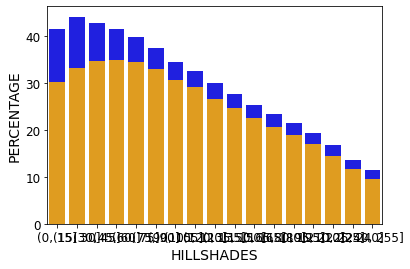

In [65]:
#B.2.3) ANALYSIS : hillshade study
df_temp = df.melt(id_vars="HILLSHADES", 
              var_name="CLASSIFIER", 
              value_name="CLASS")
bins = [0,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255]
df_temp2 = df_temp.groupby(["CLASSIFIER","CLASS",pd.cut(df_temp['HILLSHADES'], bins=bins)])["CLASS"].count().to_frame("COUNT").reset_index()
df_hill_sum = df_temp.groupby(["CLASSIFIER",pd.cut(df_temp['HILLSHADES'], bins=bins)])["CLASS"].count().to_frame("COUNT").reset_index()
df_hill_1 = df_temp2.query("CLASS == 'SNOW'").reset_index()
df_hill_1["PERCENTAGE"] = df_hill_1["COUNT"]/df_hill_sum["COUNT"]*100
fig, axs = plt.subplots()
sn.barplot(ax=axs,data=df_hill_1.query("CLASSIFIER == 'PREDICTIONS'"),x="HILLSHADES",y="PERCENTAGE",color='blue')
sn.barplot(ax=axs,data=df_hill_1.query("CLASSIFIER == 'REFERENCES'"),x="HILLSHADES",y="PERCENTAGE",color='orange')

PREDICTIONS    CLOUD    GROUND     SNOW
REFERENCES                             
CLOUD        9558099    216609   828379
GROUND        255772  14197165   834799
SNOW          473695     42290  6346051
0.8737175790816707 0.919043891710339 (0.954630208648525, 0.8534648531917091, 0.9150598595457979) (0.9286636687080415, 0.9248058447959178, 0.901444928255328) (0.9820906299252687, 0.7923423091036603, 0.9290923625666169)


<AxesSubplot:xlabel='PREDICTIONS', ylabel='REFERENCES'>

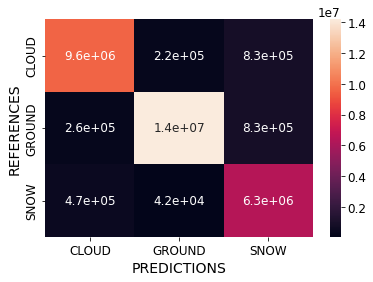

In [70]:
#B.2.4) ANALYSIS : make confusion matrix
def getCM3metrics(cm11,cm12,cm13,cm21,cm22,cm23,cm31,cm32,cm33):
    #calculation of class 1 metrics
    TP_1 = cm11
    TN_1 = cm22 + cm33 + cm23 + cm32
    FP_1 = cm21 + cm31
    FN_1 = cm12 + cm13
    Precision_1 = TP_1/(TP_1 + FP_1)
    Recall_1 = TP_1/(TP_1+FN_1)
    F1_1 = 2*Precision_1*Recall_1/(Precision_1+Recall_1)

    #calculation of class 2 metrics
    TP_2 = cm22
    TN_2 = cm11 + cm33 + cm13 + cm31
    FP_2 = cm12 + cm32
    FN_2 = cm21 + cm23
    Precision_2 = TP_2/(TP_2 + FP_2)
    Recall_2= TP_2/(TP_2+FN_2)
    F1_2= 2*Precision_2*Recall_2/(Precision_2+Recall_2)

    #calculation of class 3 metrics
    TP_3 = cm33
    TN_3 = cm11 + cm22 + cm12 + cm21
    FP_3 = cm13 + cm23
    FN_3 = cm31 + cm32
    Precision_3= TP_3/(TP_3 + FP_3)
    Recall_3= TP_3/(TP_3+FN_3)
    F1_3= 2*Precision_3*Recall_3/(Precision_3+Recall_3)
    
    #calculation of multiclass metrics
    total = cm11+cm12+cm13+cm21+cm22+cm23+cm31+cm32+cm33
    Agree = (cm11+cm22+cm33)/total
    ChanceAgree1 =(cm11+cm12+cm13)/total * (cm11+cm21+cm31)/total
    ChanceAgree2 =(cm21+cm22+cm23)/total * (cm12+cm22+cm32)/total
    ChanceAgree3 =(cm31+cm32+cm33)/total * (cm13+cm23+cm33)/total
    ChanceAgree = ChanceAgree1 + ChanceAgree2 + ChanceAgree3 
    kappa = (Agree - ChanceAgree)/(1 - ChanceAgree)
    micro_precision = (TP_1+TP_2+TP_3)/(TP_1+TP_2+TP_3+FP_1+FP_2+FP_3)
    micro_recall = (TP_1+TP_2+TP_3)/(TP_1+TP_2+TP_3+FN_1+FN_2+FN_3)
    micro_F1 = 2*micro_precision*micro_recall/(micro_precision+micro_recall)
    macro_precision = (Precision_1+Precision_2+Precision_3)/3.0
    macro_recall = (Recall_1+Recall_2+Recall_3)/3.0
    macro_F1 = (F1_1+F1_2+F1_3)/3.0
    OA = Agree

    return kappa, OA, [F1_1, F1_2, F1_3], [Recall_1, Recall_2, Recall_3], [Precision_1, Precision_2, Precision_3]



df["COUNT"]=1
df_cm = df.groupby(["REFERENCES","PREDICTIONS"])["COUNT"].count().to_frame('COUNT').reset_index().pivot(index="REFERENCES", columns="PREDICTIONS", values="COUNT")

cmGG = df_cm.loc['GROUND', 'GROUND']
cmGS = df_cm.loc['GROUND', 'SNOW']
cmGC = df_cm.loc['GROUND', 'CLOUD']
cmSG = df_cm.loc['SNOW', 'GROUND']
cmSS = df_cm.loc['SNOW', 'SNOW']
cmSC = df_cm.loc['SNOW', 'CLOUD']
cmCG = df_cm.loc['CLOUD', 'GROUND']
cmCS = df_cm.loc['CLOUD', 'SNOW']
cmCC = df_cm.loc['CLOUD', 'CLOUD']
print(df_cm)
kappa,OA,(F1_G,F1_S,F1_C),(Recalls_G,Recalls_S,Recalls_C),(Precisions_G,Precisions_S,Precisions_C) = getCM3metrics(cmGG,cmGS,cmGC,cmSG,cmSS,cmSC,cmCG,cmCS,cmCC)

print(kappa,OA,(F1_G,F1_S,F1_C),(Recalls_G,Recalls_S,Recalls_C),(Precisions_G,Precisions_S,Precisions_C) )
sn.heatmap(data=df_cm,annot=True)

In [ ]:
#B.3) MODEL EVALUATION USING HISTORICAL SPOT DATA (PRODUCED BY SIMON GASCOIN)

In [3]:
#B.3.1) INFERENCE OF GASCOIN DATA
import os
simon_swh_path = os.path.join(project_dir,"DATA/HISTORICAL_SWH_SIMON_GASCOIN")
refl_list = os.path.join(simon_swh_path,'LIST','list.txt')
snow_dir = os.path.join(simon_swh_path,'L2B')
model_dir = os.path.join(project_dir,"MODELS_USED_FOR_UNET_PAPER/TCD-ONLY_SPOT4-NOSWIR")
out_dir = os.path.join(simon_swh_path,'INFERENCE')


script_path = os.path.join(project_dir,"CODE","trex","run_snow_swh_job.sh")



export =  ",".join(
    [
        f"INPUT_PATH=\"{refl_list}\"", f"OUTPUT_PATH=\"{out_dir}\"", f"MODELS_PATH=\"{model_dir}\"", f"KEEP_REFL=\"0\"", f"MASK=\"1\""
    ]
)

job_common_params =  " ".join(
    [
        "-A","cnes_level2",
        " --job-name=GASCOIN_EVAL",
        " --time=00:09:59",
        "-N","1","-n","8",
        "--mem=196G",
        "-o",f"{project_dir}/CODE/logs/GASCOIN_EVAL",
        f"--export=ALL,{export}",script_path
    ]
)

os.system("sbatch "+job_common_params)  

Submitted batch job 24456014


0

<font size="12">Trends in the annual snow melt-out day over the French Alps and the Pyrenees from 38 years of high resolution satellite data</font>

In [ ]:
#C) PREPARE 38 YEARS OF SNOW DATA

In [ ]:
#C.1) CLASSIFY SWH DATA

In [ ]:
# C.1.1) MAKE LISTS OF SWH DATA USING S3FS
#use kernel s3-env
#if s3fs generate errors, try running the command 'kinit' (followed by pwd) in the console before trying again.

lists_path = os.path.join(project_dir,"DATA",'SWH_PRODUCTS',"LISTS")
os.system(f"mkdir -p {lists_path}")

ENDPOINT_URL="https://s3.datalake.cnes.fr"
credentials = assumerole.getCredentials("arn:aws:iam::732885638740:role/public-read-only-OT", Duration=7200)
s3 = s3fs.S3FileSystem(
      client_kwargs={
                      'aws_access_key_id': credentials['AWS_ACCESS_KEY_ID'],
                
          'aws_secret_access_key': credentials['AWS_SECRET_ACCESS_KEY'],
                      'aws_session_token': credentials['AWS_SESSION_TOKEN'],
         'endpoint_url': 'https://s3.datalake.cnes.fr'
      }
   )

SPOT_tile={
    "ALP":
    {"KMIN":46,
     "KMAX":55,
     "JMIN":254,
     "JMAX":263
    },
    "PYR":
    {"KMIN":35,
     "KMAX":48,
     "JMIN":262,
     "JMAX":265
    }
}
for mtn in ["PYR","ALP"]:
    os.system(f"mkdir -p {lists_path}/{mtn}")
    for sat in ["SPOT1","SPOT2","SPOT3","SPOT4","SPOT5"]:
        for year in range(1986,2016):
            for K in range(SPOT_tile[mtn]["KMIN"],SPOT_tile[mtn]["KMAX"]+1):
                for J in range(SPOT_tile[mtn]["JMIN"],SPOT_tile[mtn]["JMAX"]+1):
                    s3_list = s3.glob(f"muscate/SPOTWORLDHERITAGE/{str(year)}/**/{str(sat)}*_0{str(K)}-{str(J)}-*.zip")
                    if len(s3_list) > 0:
                        with open(os.path.join(lists_path,mtn,f"{mtn}_{str(sat)}_{str(year)}.txt"), 'w') as fp:
                            for item in s3_list:
                                fp.write(item+"\n")  

In [ ]:
# C.1.2) APPLY UNET ON SWH LISTS



model_dir = os.path.join(project_dir,"MODELS_USED_FOR_TRENDS/TCD-BLUE")

out_dir = os.path.join(project_dir,'DATA','SWH_PRODUCTS','INFERENCE')


lists_path = os.path.join(project_dir,"DATA",'SWH_PRODUCTS',"LISTS")
for i,ll in enumerate(os.listdir(lists_path)):
    
    


    script_path = os.path.join(project_dir,"CODE","trex","run_snow_swh_job.sh")



    export =  ",".join(
        [
            f"INPUT_PATH=\"{os.path.join(lists_path,ll)}\"", f"OUTPUT_PATH=\"{out_dir}\"", f"MODELS_PATH=\"{model_dir}\"", f"KEEP_REFL=\"0\"", f"MASK=\"1\""
        ]
    )

    job_common_params =  " ".join(
        [
            "-A","cnes_level2",
            f" --job-name=INF_{i}",
            " --time=00:09:59",
            "-N","1","-n","8",
            "--mem=196G",
            "-o",f"{project_dir}/CODE/logs/INF_{i}",
            f"--export=ALL,{export}",script_path
        ]
    )

    os.system("sbatch "+job_common_params)  

